In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pickle
import csv
import os
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

%matplotlib inline

path="C:\\Users\\Anjana Puri\\Documents\\Python\\TennisProject\\JosephSackmann Data\\tennis_atp-master\\tennis_atp-master"
os.chdir(path)

In [2]:
#This cell imports all of the data files that will be relevant to our calculations

pickle_file = "player_serve_info.pkl"
with open(pickle_file, 'rb') as handle:
    player_serve_info = pickle.load(handle)
    
pickle_file = "player_match_number_info.pkl"
with open(pickle_file, 'rb') as handle:
    num_matches = pickle.load(handle)
    
pickle_file = "name_to_id.pkl"
with open(pickle_file, 'rb') as handle:
    name_to_id = pickle.load(handle)

pickle_file = "id_to_name.pkl"
with open(pickle_file, 'rb') as handle:
    id_to_name = pickle.load(handle)

    
with open('active_players.csv', 'r') as f:
    reader = csv.reader(f)
    player_list = list(reader)
active_player_list=[''.join(x) for x in list(filter(lambda a: a != [], player_list))]    

with open('top_30_players.csv', 'r') as f:
    reader = csv.reader(f)
    top_player_list = list(reader)
top_player_list=[''.join(x) for x in list(filter(lambda a: a != [], top_player_list))] 

mc_df= pd.read_pickle('MC_results.pkl')


In [3]:
%matplotlib inline

#let's import our Monte Carlo results dataframe (see ATP_serving strategies repository) and restrict it to data on active players who have been ranked in the top30
top30=mc_df.copy().reset_index()
p1_bool_list=list(top30['Player 1 Name'].apply(lambda x: True if (name_to_id[x] in top_player_list) and (name_to_id[x] in active_player_list) else False))
p2_bool_list=list(top30['Player 2 Name'].apply(lambda x: True if (name_to_id[x] in top_player_list) and (name_to_id[x] in active_player_list) else False))
top30=top30[[i and j for i,j in zip(p1_bool_list,p2_bool_list)]]

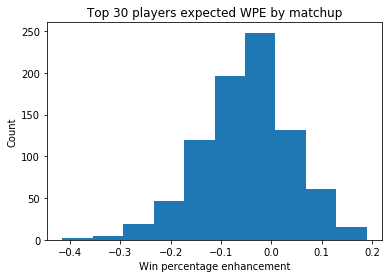

Percentage of matchups that benefit from strategy switch: 0.27


In [4]:
#creates a historgram of expcted win percentage enhancements for each matchup from switching to a risky strat. for all matchups in dataframe

expected_wpe=list(top30['Delta MC Results'])
plt.figure()
plt.hist(expected_wpe)
plt.xlabel('Win percentage enhancement')
plt.ylabel('Count')
plt.title('Top 30 players expected WPE by matchup')
plt.show()

print("Percentage of matchups that benefit from strategy switch: {:.2f}".format(len([i for i in expected_wpe if i>0])/len(expected_wpe)))

Percentage of active top 30 players that would benefit from a global strategy switch: 0.26


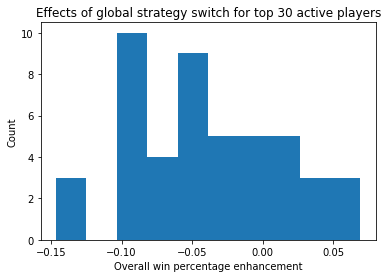

In [5]:
#what if players switched to a risky strategy for all matches? This historgram plots the expected global win percentage enhancement
#by weighting each matchup values by the number of matches in the matchup

top30['Weighted WP']=top30['Real life number of matches']*top30['Delta MC Results']
grouped_top30=top30.groupby(by='Player 1 (P1)')
top30_overall_wpe=list(grouped_top30['Weighted WP'].sum()/grouped_top30['Real life number of matches'].sum())

plt.figure()
plt.hist(top30_overall_wpe)
plt.xlabel('Overall win percentage enhancement')
plt.ylabel('Count')
plt.title('Effects of global strategy switch for top 30 active players')

print("Percentage of active top 30 players that would benefit from a global strategy switch: {:.2f}".format(len([i for i in top30_overall_wpe if i>0])/len(top30_overall_wpe)))

In [6]:
#Now I want to answer the following question: How many matches must there be in a player matchup before I can have confidence in
#saying which strategy is optimal?

#let's first restrict ourselves to matches where there are at least 15 matches
df=pd.read_pickle('enhancement_metrics.pkl')
match_number_df=df.copy().reset_index()
match_number_df=match_number_df[match_number_df['Number of Matches']>15]

#list of all point-averafed EM factors
em_history=list(match_number_df['P1 Total EM Series'])

In [7]:
#list of user defined functions

def moving_av(x):
    mean_vec=[0]*len(x)
    for i in range(len(x)):
        mean_vec[i]=np.mean(x[:(i+1)])
    return mean_vec

mean_list=[moving_av(x) for x in em_history]

def mean_converge(x,margin):
    last_val=x[-1]
    mean_temp=[i-last_val for i in x]
    converge=[1 if abs(i)<abs(margin) else 0 for i in mean_temp]
    converge_index=1
    for j in range(len(converge)):
        if converge[j]==0:
            converge_index=j
    return (mean_temp,converge_index)

def correct_sign(x):
    converge=[1 if np.sign(i)==np.sign(x[-1]) else 0 for i in x]
    converge_index=1
    for j in range(len(converge)):
        if converge[j]==0:
            converge_index=j+2
    return converge_index


Text(0.5, 1.0, 'Active top 30 matchup EM factors')

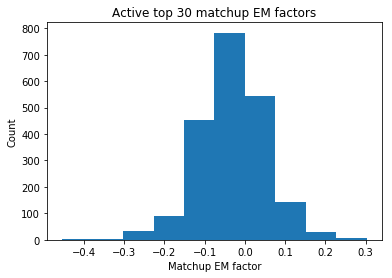

In [8]:
#first load the serving data for all top30 active players

global_EM=pd.read_pickle('enhancement_metrics.pkl').reset_index()
global_EM=global_EM[global_EM['Player 1 (P1)'].apply(lambda x: True if (x in top_player_list) and (x in active_player_list) else False)]
global_EM=global_EM[global_EM['Player 2 (P2)'].apply(lambda x: True if (x in top_player_list) and (x in active_player_list) else False)]

#now extract the various EM factors for each matchup

#the following list is the match-averaged EM factor (see below for more details)
game_av_em=[np.mean(ele) for ele in list(global_EM['P1 Total EM Series'])]
plt.figure()
plt.hist(game_av_em)
plt.xlabel('Matchup EM factor')
plt.ylabel('Count')
plt.title('Active top 30 matchup EM factors')

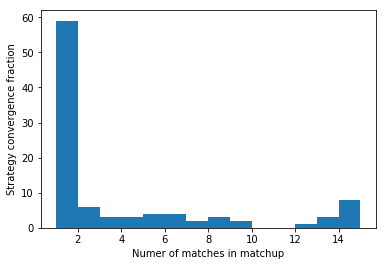

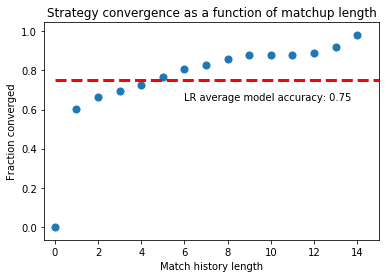

In [9]:
#Now check for the number of matches it took for the moving average of EM factors to match the sign of the 15-match avergae
#i.e. how matches did it take to converge on a strategy?
n_converge=[correct_sign(i[:15]) for i in mean_list]


plt.figure()
plt.hist(n_converge,bins=14)
plt.xlabel('Numer of matches in matchup')
plt.ylabel('Strategy convergence fraction')

cdf=[len([i for i in n_converge if i <=j])/len(n_converge) for j in range(15)]

#We see that after 3 matches, roughly 70% of matchups have converged
# we will keep this in mind later when trying to determine how to predict strategies for players with little matchup history
# (spoiler) we will develop a logistic regression model to predict this, with an average model accuracy of 71% (see below)

plt.figure()
plt.scatter(range(15),cdf,s=50,label='Player data')
plt.plot(range(20),[.75]*20,color='red',linestyle='--',linewidth=3,label='RFC av. accuracy')
plt.xlabel('Match history length')
plt.ylabel('Fraction converged')
plt.xlim(-.50,15)
plt.title('Strategy convergence as a function of matchup length')
plt.text(6,.65,s='LR average model accuracy: 0.75')
plt.savefig('strategy_convergence.png')




Text(0.5, 1.0, 'Matchup-averaged EM factor')

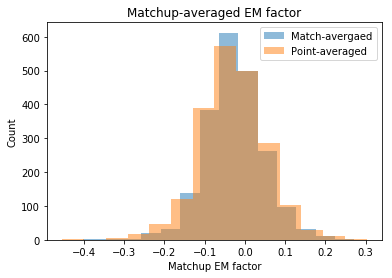

In [10]:
#side question: should I calculate the EM factor by averaging the matchup-EM across all matches
#or should I consider all points played between two players and average those?

#this is a list of point averaged EM factors
#we can plot the two sets against one another
g_em_history=list(global_EM['P1 Global EM'])
plt.figure()
plt.hist(g_em_history,bins=14,alpha=.5,label='Match-avergaed')
plt.hist(game_av_em,bins=14,alpha=.5,label='Point-averaged')
plt.legend()
plt.xlabel('Matchup EM factor')
plt.ylabel('Count')
plt.title('Matchup-averaged EM factor')

Fraction of averages with different signs: 0.13


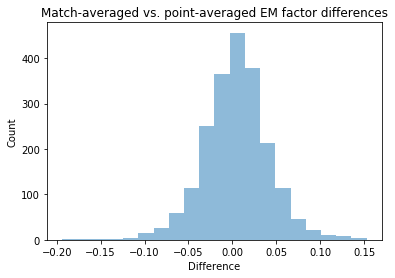

In [11]:
plt.figure()
plt.hist(np.array(g_em_history)-np.array(game_av_em),bins=20,alpha=.5)
plt.xlabel('Difference')
plt.ylabel('Count')
plt.title('Match-averaged vs. point-averaged EM factor differences')

#roughly 90% of strategy predicitons are the same with each model so we'll just stick with point averages for now
print("Fraction of averages with different signs: {:.2f}".format(len([g_em_history[i] for i in range(len(g_em_history)) if (not np.sign(g_em_history[i])==np.sign(game_av_em[i]))])/len([i for i in range(len(g_em_history))])))


In [12]:
#okay now we are going to develop a machine learning model to predict strategies for players without significant match history

min_matches=1

#let's load in an active player data frame (will be used to construct features)
df=pd.read_pickle('enhancement_metrics.pkl')
df_features=df.copy().reset_index()
df_features=df_features[df_features['Player 1 (P1)'].apply(lambda x: True if (x in active_player_list) else False)]
df_features=df_features[df_features['Player 2 (P2)'].apply(lambda x: True if (x in active_player_list) else False)]
df_features=df_features.set_index(['Player 1 (P1)','Player 2 (P2)'])

#now lets' load in another top30 active dataframe and restrict ourselves to players with over 3 matches (will be used to construct training data)
#I selected a matchup history of 3 here so that we could use the matchup data for each matchup to have a reasonable idea of what strategy is optimal (see above)
#this allows us to assign each matchup in this dataframe to a strategy class: {1=risky strat is better, 0=safe strat is better}
df.reset_index(inplace=True)
df=df[df['Player 1 (P1)'].apply(lambda x: True if (x in top_player_list) and (x in active_player_list) else False)]
df=df[df['Player 2 (P2)'].apply(lambda x: True if (x in top_player_list) and (x in active_player_list) else False)]
df=df[df['Number of Matches']>=min_matches]
df_predicts=df.copy().set_index(['Player 1 (P1)','Player 2 (P2)'])
player_list=list(df['Player 1 (P1)'].drop_duplicates())
player_feature_list=df_features.reset_index()['Player 1 (P1)'].drop_duplicates()
df.set_index('Player 2 (P2)',inplace=True)
class_df=top30.copy().set_index('Player 2 (P2)')

print(len(df))


2088


Percentage of classification agreement: 0.94


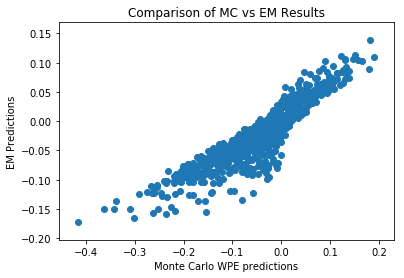

In [13]:
#The first thing I want to know if how to do the class determinaton
#I could use either the MC simulation results or the EM factor for each matchup
#the MC results are more likely to be accurate predictors on which strat will work but also I have less data here so I won't be able to train
#on as many points
#I have more EM facor data but they are maybe less reliable
#Let's see how these factors correlate with one another

mc_predicts=class_df.reset_index()[['Player 1 (P1)','Player 2 (P2)','Delta MC Results']]
common_matchups=mc_predicts[['Player 1 (P1)','Player 2 (P2)']].values
mc_predicts=mc_predicts.set_index(['Player 1 (P1)','Player 2 (P2)'])

mc_points=[]
em_points=[]
for matchup in common_matchups:
    try:
        mc_points.append(mc_predicts.loc[matchup[0],matchup[1]]['Delta MC Results'])
        em_points.append(df_predicts.loc[matchup[0],matchup[1]]['P1 Global EM'])
    except KeyError:
        continue
        
plt.figure()
plt.scatter(mc_points,em_points)
plt.xlabel('Monte Carlo WPE predictions')
plt.ylabel('EM Predictions')
plt.title('Comparison of MC vs EM Results')

print("Percentage of classification agreement: {:.2f}".format(len([i for i in range(len(mc_points)) if np.sign(em_points[i])==np.sign(mc_points[i])])/len(mc_points)))

#given they agree 94% of the time, I am going to use the EM result and trade the slight drop in accuracy for significantly more data


In [14]:
scores=[]
dummy_scores=[]
track_strat_success=[]

#now we will construct dataframes to base our machine learning training data on for each player
#basically we will look at all players who have served against a particular opponent who have at least 3 matches against them
#each player's class is determined by their EM factor against this player (risky vs safe)

#We will look at these players serving percentages against all players in player_features_list
#we will construct a matrix of FSWP and SSWP for these players and use this to train based off the classes assigned earlier

for index,current_player in enumerate(player_list):
    #get allow matchups involving current_player
    player_slice=df.loc[current_player]
    #make sure there are at least 15 such matches (we need a reasonably sized training set)
    if len(player_slice)<15:
        continue
    #get list of all opponent id numbers
    opponents=list(player_slice['Player 1 (P1)'])
    #determine the opponent class by whether the EM factor is greater than 0
    opp_class=list(player_slice['P1 Global EM']>0)    
    #print out the number of opponents who benefit from a risky strat against current_player
    print(id_to_name[current_player]+" RL strategy success percentage: {:.2f}".format((player_slice['P1 Global EM']>0).mean()))
    track_strat_success.append((player_slice['P1 Global EM']>0).mean())
    
    #now for every opponent we want to construct a feature matrix   
    ml_df=pd.DataFrame(opponents)
    
    
    for active_player in player_feature_list:
        #player_feature_list contains a list of all active ATP players
        #consider an active_player within this list
        
        vector_fswp=[]
        vector_sswp=[]
        #loop tracking variable
        player_hit=0
        
        for player in opponents:
            #for every opponent that current_player has faced
            #determine what his FSWP and SSWP is against active_player
            try:
                data_slice=df_features.loc[player,active_player]
                vector_fswp.append(data_slice['Serve percentages'][0]*data_slice['Serve percentages'][1])
                vector_sswp.append(data_slice['Serve percentages'][2]*data_slice['Serve percentages'][3])
                player_hit+=1
            except KeyError:
                #if they've never played, list this value as 0

                opp_serve_info=list(df_features.loc[pd.IndexSlice[:, active_player], :]["Serve percentages"])
                av_serves=[sum(y) / len(y) for y in zip(*opp_serve_info)]
                vector_fswp.append(av_serves[0]*av_serves[1])
                vector_sswp.append(av_serves[2]*av_serves[3])
        #If no opponent has played active_player before, player_hit=0 and we should not consider this feature in our training model 
        #other_wise, add this active_player feature vector a dataframe
        if player_hit>0:
            ml_df[active_player+'_fswp']=pd.Series(vector_fswp)
            ml_df[active_player+'_sswp']=pd.Series(vector_sswp)
    
    #now we can remove the opponent names from our feature data dataframe
    ml_df=ml_df.drop(ml_df.columns[0],axis=1)
    
    #with the feature data in hand we can train a ML model to our data (more on this later)
    X_train,X_test,y_train,y_test=train_test_split(ml_df,opp_class)
    
    #Make sure we have at least 10 points to train on or else don't bother
    if len(X_train)<10:
        continue
    #use logistic regression training model
    lr=LogisticRegression(C=5).fit(X_train, y_train)
    
    #compare reuslts to stratified dummy classifier
    dum = DummyClassifier()
    dum.fit(X_train,y_train)
    
    #save the dummy/lr accuracy scores as well as the training/class data matrices for each player
    scores.append([id_to_name[current_player],lr,ml_df.columns,lr.score(X_train,y_train),lr.score(X_test,y_test),X_train,y_train,X_test,y_test,ml_df,opp_class])
    dummy_scores.append([id_to_name[current_player],dum,dum.score(X_train,y_train),dum.score(X_test,y_test)])
    print(id_to_name[current_player]+" model accuracy score: {:.2f}".format(lr.score(X_test,y_test)))
    if index%4==0:
        print("Percent completed: {:.2f}".format(index/len(player_list)))



Alexander Zverev RL strategy success percentage: 0.36


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Alexander Zverev model accuracy score: 0.50
Percent completed: 0.00
Ivo Karlovic RL strategy success percentage: 0.12


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Ivo Karlovic model accuracy score: 0.82
Roger Federer RL strategy success percentage: 0.24


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Roger Federer model accuracy score: 1.00
Feliciano Lopez RL strategy success percentage: 0.19


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Feliciano Lopez model accuracy score: 1.00
David Ferrer RL strategy success percentage: 0.45


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


David Ferrer model accuracy score: 0.75
Percent completed: 0.08
Guillermo Garcia Lopez RL strategy success percentage: 0.23


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Guillermo Garcia Lopez model accuracy score: 1.00
Philipp Kohlschreiber RL strategy success percentage: 0.33


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Philipp Kohlschreiber model accuracy score: 1.00
Fernando Verdasco RL strategy success percentage: 0.29


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fernando Verdasco model accuracy score: 0.75
Andreas Seppi RL strategy success percentage: 0.27


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Andreas Seppi model accuracy score: 0.67
Percent completed: 0.17
Janko Tipsarevic RL strategy success percentage: 0.45


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Janko Tipsarevic model accuracy score: 0.80
Gilles Simon RL strategy success percentage: 0.27


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Gilles Simon model accuracy score: 0.92
Stanislas Wawrinka RL strategy success percentage: 0.35


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Stanislas Wawrinka model accuracy score: 0.75
Jo Wilfried Tsonga RL strategy success percentage: 0.23


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Jo Wilfried Tsonga model accuracy score: 0.75
Percent completed: 0.25
John Isner RL strategy success percentage: 0.18


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


John Isner model accuracy score: 0.82
Marcos Baghdatis RL strategy success percentage: 0.32


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Marcos Baghdatis model accuracy score: 0.50
Lukas Rosol RL strategy success percentage: 0.38


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Lukas Rosol model accuracy score: 0.30
Tomas Berdych RL strategy success percentage: 0.46


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Tomas Berdych model accuracy score: 0.83
Percent completed: 0.33
Pablo Cuevas RL strategy success percentage: 0.26


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pablo Cuevas model accuracy score: 0.82
Viktor Troicki RL strategy success percentage: 0.28


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Viktor Troicki model accuracy score: 0.58
Marcel Granollers RL strategy success percentage: 0.23


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Marcel Granollers model accuracy score: 0.82
Kevin Anderson RL strategy success percentage: 0.22


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Kevin Anderson model accuracy score: 0.75
Percent completed: 0.42
Rafael Nadal RL strategy success percentage: 0.49


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Rafael Nadal model accuracy score: 0.75
Gael Monfils RL strategy success percentage: 0.19


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Gael Monfils model accuracy score: 0.83
Andy Murray RL strategy success percentage: 0.49


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Andy Murray model accuracy score: 0.45
Leonardo Mayer RL strategy success percentage: 0.30


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Leonardo Mayer model accuracy score: 0.40
Percent completed: 0.50
Novak Djokovic RL strategy success percentage: 0.48


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Novak Djokovic model accuracy score: 0.83
Fabio Fognini RL strategy success percentage: 0.28


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fabio Fognini model accuracy score: 0.67
Sam Querrey RL strategy success percentage: 0.23


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Sam Querrey model accuracy score: 0.64
Albert Ramos RL strategy success percentage: 0.25


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Albert Ramos model accuracy score: 0.80
Percent completed: 0.58
Roberto Bautista Agut RL strategy success percentage: 0.30


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Roberto Bautista Agut model accuracy score: 0.67
Adrian Mannarino RL strategy success percentage: 0.38


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Adrian Mannarino model accuracy score: 0.55
Ernests Gulbis RL strategy success percentage: 0.31


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Ernests Gulbis model accuracy score: 0.73
Juan Martin Del Potro RL strategy success percentage: 0.32


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Juan Martin Del Potro model accuracy score: 0.82
Percent completed: 0.67
Marin Cilic RL strategy success percentage: 0.37


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Marin Cilic model accuracy score: 0.92
Benoit Paire RL strategy success percentage: 0.33


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Benoit Paire model accuracy score: 0.82
Martin Klizan RL strategy success percentage: 0.43


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Martin Klizan model accuracy score: 0.60
Kei Nishikori RL strategy success percentage: 0.50


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Kei Nishikori model accuracy score: 0.75
Percent completed: 0.75
David Goffin RL strategy success percentage: 0.40


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


David Goffin model accuracy score: 0.92
Milos Raonic RL strategy success percentage: 0.20


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Milos Raonic model accuracy score: 0.83
Grigor Dimitrov RL strategy success percentage: 0.27


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Grigor Dimitrov model accuracy score: 0.83
Pablo Carreno Busta RL strategy success percentage: 0.54


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pablo Carreno Busta model accuracy score: 0.40
Percent completed: 0.83
Damir Dzumhur RL strategy success percentage: 0.41


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Damir Dzumhur model accuracy score: 0.80
Diego Sebastian Schwartzman RL strategy success percentage: 0.53


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Diego Sebastian Schwartzman model accuracy score: 0.82
Jack Sock RL strategy success percentage: 0.34


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Jack Sock model accuracy score: 0.73
Bernard Tomic RL strategy success percentage: 0.42


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Bernard Tomic model accuracy score: 0.67
Percent completed: 0.92
Dominic Thiem RL strategy success percentage: 0.33


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Dominic Thiem model accuracy score: 0.83
Lucas Pouille RL strategy success percentage: 0.38


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Lucas Pouille model accuracy score: 0.50
Nick Kyrgios RL strategy success percentage: 0.50
Nick Kyrgios model accuracy score: 0.89


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
#let's compare the dummy/lr accuracy scores
from scipy import stats
print('LR train score mean: {:.2f}  Standard Deviation: {:.2f}'.format(np.mean([i[3] for i in scores]),np.std([i[3] for i in scores])))
print('LR test score mean: {:.2f}  Standard Deviation: {:.2f}'.format(np.mean([i[4] for i in scores]),np.std([i[4] for i in scores])))
print('Dummy train score mean: {:.2f}  Standard Deviation: {:.2f}'.format(np.mean([i[2] for i in dummy_scores]),np.std([i[2] for i in dummy_scores])))
print('Dummy test score mean: {:.2f}  Standard Deviation: {:.2f}'.format(np.mean([i[3] for i in dummy_scores]),np.std([i[3] for i in dummy_scores])))
stats.ttest_ind([i[4] for i in scores],[i[3] for i in dummy_scores],equal_var=False)

LR train score mean: 0.97  Standard Deviation: 0.03
LR test score mean: 0.74  Standard Deviation: 0.16
Dummy train score mean: 0.58  Standard Deviation: 0.10
Dummy test score mean: 0.53  Standard Deviation: 0.18


Ttest_indResult(statistic=5.895745595738281, pvalue=5.890292762756079e-08)

In [16]:

#we can now try to optimize our ML model parameters for each player
#first let's try a RandomForest Classifier

from sklearn.model_selection import GridSearchCV

#optimized parameter and accuracy score variables
op_params=[]
op_best_scores=[]
params={'max_depth':[1,2,3,4],'n_estimators':[10,50,100,200,500]}

rfc_scores=copy.deepcopy(scores)

#loop over every player
for i,player in enumerate(scores):
    print("Percent complete: {:.2f}".format(i/len(player_list)))
    X_train,X_test,y_train,y_test=(scores[i][5],scores[i][7],scores[i][6],scores[i][8])
    grd_rfc=GridSearchCV(RandomForestClassifier(),param_grid=params,cv=3)
    grd_rfc.fit(X_train,y_train)
    rfc=RandomForestClassifier(max_depth=grd_rfc.best_params_["max_depth"],n_estimators=grd_rfc.best_params_["n_estimators"]).fit(X_train,y_train)
    rfc_scores[i][1]=rfc
    rfc_scores[i][3]=rfc.score(X_train,y_train)
    rfc_scores[i][4]=rfc.score(X_test,y_test)
    op_params.append(list(grd_rfc.best_params_.values()))
    op_best_scores.append(rfc.score(X_test,y_test))

Percent complete: 0.00


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.02


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.04


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.06


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.08


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.10


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.12


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.15


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.17
Percent complete: 0.19


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.21


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.23


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.25


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.27
Percent complete: 0.29


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.31


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.33


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.35


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.38


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.40


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.42


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.44


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.46


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.48


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.50
Percent complete: 0.52


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.54


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.56
Percent complete: 0.58


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.60


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.62


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.65


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.67


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.69


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.71


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.73
Percent complete: 0.75


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.77


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.79


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.81


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.83


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.85


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.88


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.90


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.92
Percent complete: 0.94


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.96


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.98


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [17]:
#averaged optimized accuracy score
np.mean(op_best_scores)

0.6934553872053871

In [18]:
# we can now do a grid search to optimzie our lr model
#here will save our optimized models to the 'score' matrix

params={'n_neighbors':[1,2,3,4,5]}
knn_scores=copy.deepcopy(scores)
op_knn_best_scores=[]
op_knn_best_params=[]

for i,player in enumerate(scores):
    print("Percent complete: {:.2f}".format(i/len(player_list)))
    X_train,X_test,y_train,y_test=(scores[i][5],scores[i][7],scores[i][6],scores[i][8])
    grd_knn=GridSearchCV(KNeighborsClassifier(),param_grid=params,cv=3)
    grd_knn.fit(X_train,y_train)
    knn=KNeighborsClassifier(n_neighbors=grd_knn.best_params_["n_neighbors"]).fit(X_train,y_train)
    knn_scores[i][1]=knn
    knn_scores[i][3]=knn.score(X_train,y_train)
    knn_scores[i][4]=knn.score(X_test,y_test)
    op_knn_best_scores.append(knn.score(X_test,y_test))
    op_knn_best_params.append(list(grd_knn.best_params_.values()))

Percent complete: 0.00
Percent complete: 0.02
Percent complete: 0.04


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_se

Percent complete: 0.06
Percent complete: 0.08


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.10
Percent complete: 0.12
Percent complete: 0.15
Percent complete: 0.17


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.19
Percent complete: 0.21


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.23
Percent complete: 0.25


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.27
Percent complete: 0.29


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.31
Percent complete: 0.33


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.35
Percent complete: 0.38


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.40
Percent complete: 0.42


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.44
Percent complete: 0.46


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.48
Percent complete: 0.50
Percent complete: 0.52
Percent complete: 0.54
Percent complete: 0.56


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.58
Percent complete: 0.60


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.62
Percent complete: 0.65


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.67
Percent complete: 0.69


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.71
Percent complete: 0.73


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.75
Percent complete: 0.77


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.79
Percent complete: 0.81


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.83
Percent complete: 0.85


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.88
Percent complete: 0.90


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.92
Percent complete: 0.94


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Percent complete: 0.96
Percent complete: 0.98


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
print(np.mean(np.array(op_knn_best_scores)))
print(np.mean(np.array(op_knn_best_params)))

0.6864372895622896
2.6666666666666665


In [20]:
# we can now do a grid search to optimzie our lr model
#here will save our optimized models to the 'score' matrix

params={'C':[.1,1,10,100,5]}
lr_scores=copy.deepcopy(scores)
op_lr_best_scores=[]
op_lr_best_params=[]
for i,player in enumerate(scores):
    print("Percent complete: {:.2f}".format(i/len(player_list)))
    X_train,X_test,y_train,y_test=(scores[i][5],scores[i][7],scores[i][6],scores[i][8])
    if sum(y_train)<3:
        continue
    grd_lr=GridSearchCV(LogisticRegression(),param_grid=params,cv=3)
    grd_lr.fit(X_train,y_train)
    lr=LogisticRegression(C=grd_lr.best_params_["C"]).fit(X_train,y_train)
    lr_scores[i][1]=lr
    lr_scores[i][3]=lr.score(X_train,y_train)
    lr_scores[i][4]=lr.score(X_test,y_test)
    op_lr_best_scores.append(lr.score(X_test,y_test))
    op_lr_best_params.append(list(grd_lr.best_params_.values()))

    

C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.00
Percent complete: 0.02


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.04
Percent complete: 0.06


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.08
Percent complete: 0.10
Percent complete: 0.12


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will cha

Percent complete: 0.15
Percent complete: 0.17
Percent complete: 0.19


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.21
Percent complete: 0.23
Percent complete: 0.25

C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will cha


Percent complete: 0.27
Percent complete: 0.29


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.31
Percent complete: 0.33
Percent complete: 0.35


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.38
Percent complete: 0.40


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.42


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.44
Percent complete: 0.46
Percent complete: 0.48

C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.


Percent complete: 0.50
Percent complete: 0.52


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.54
Percent complete: 0.56


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.58
Percent complete: 0.60


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.62
Percent complete: 0.65


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.67
Percent complete: 0.69
Percent complete: 0.71


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn

Percent complete: 0.73
Percent complete: 0.75


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.77
Percent complete: 0.79


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.81
Percent complete: 0.83


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.85
Percent complete: 0.88


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.90
Percent complete: 0.92

C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Percent complete: 0.94
Percent complete: 0.96
Percent complete: 0.98


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anjana Puri\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

In [21]:
#print(np.mean(np.array(op_knn_params)))
#look at optimized accuracy score
print(np.mean(np.array(op_lr_best_scores)))

0.7533249158249159


In [124]:
#function that predicts the probability of a risky strat being successful in a given matchup
p_serve_info=pd.read_pickle('enhancement_metrics.pkl')

def predict_strat(p1,p2,score_matrix):
    #p1 is the server
    #p2 is the returner
    
    #check to see if a model exists for p2
    #if not return (0,0)
    if not p2 in [name_to_id[i[0]] for i in score_matrix]:
        return (0,0,p1,p2)
    
    p_id=p1
    opp=p2
    
    #retrieve's p2's ML model
    oppInfo=[i for i in score_matrix if i[0]==id_to_name[opp]]
    
    #get a list of all player's who were used to construct the feature matrix for each model
    oppColumns=[name.strip("_fswp").strip("_sswp") for name in list(oppInfo[0][2])]
    dataArray=[]    
    #now load a dataframe slice that contains all match info for p1
    player_data=p_serve_info.loc[p_id]
    
    #append to dataArray p1's FSWP and SSWP against each player in oppColumns
    for item in oppColumns[::2]:
        try:
            dataArray.append(player_data.loc[item]['Serve percentages'][0]*player_data.loc[item]['Serve percentages'][1])
            dataArray.append(player_data.loc[item]['Serve percentages'][2]*player_data.loc[item]['Serve percentages'][3])
        except KeyError:
            opp_av_serve_info=list(df_features.loc[pd.IndexSlice[:, opp], :]["Serve percentages"])
            av_serves=[sum(y) / len(y) for y in zip(*opp_av_serve_info)]
            dataArray.append(av_serves[0]*av_serves[1])
            dataArray.append(av_serves[2]*av_serves[3])        
     
    player_df=pd.DataFrame(columns=oppColumns)
    player_df.loc[0]=dataArray
    #with dataframe now inhand return the model predicitons as well as it's prob
    return (oppInfo[0][1].predict(player_df)[0],oppInfo[0][1].predict_proba(player_df)[0,1],id_to_name[p1],id_to_name[p2])


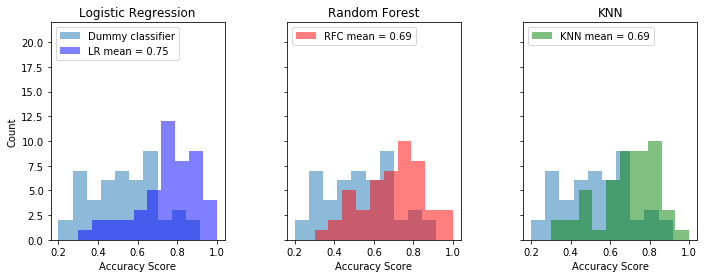

In [23]:
#history comparing accruacy scores of model vs dummy classifier

figsize = plt.figaspect(float(2) / float(6))
                        
fig,axes=plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=figsize)


axes[0].hist([i[3] for i in dummy_scores],alpha=.5,bins=10,label='Dummy classifier')
l0=axes[0].hist([i[4] for i in lr_scores],color='blue',alpha=.5,bins=10,label='LR mean = {:.2f}'.format(np.mean([i[4] for i in lr_scores])))
axes[0].set_ylim(0,22)
axes[0].set_aspect(.05)
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Accuracy Score')
axes[0].legend(loc='upper left')
axes[0].set_title('Logistic Regression')

axes[1].hist([i[3] for i in dummy_scores],alpha=.5,bins=10)
l1=axes[1].hist([i[4] for i in rfc_scores],color='red',alpha=.5,bins=10,label='RFC mean = {:.2f}'.format(np.mean([i[4] for i in rfc_scores])))
axes[0].set_aspect(.05)
axes[1].set_xlabel('Accuracy Score')
axes[1].set_aspect(.05)
axes[1].set_title('Random Forest')
axes[1].legend(loc='upper left')
axes[2].hist([i[3] for i in dummy_scores],alpha=.5,bins=10)
l2=axes[2].hist([i[4] for i in knn_scores],color='green',alpha=.5,bins=10,label='KNN mean = {:.2f}'.format(np.mean([i[4] for i in knn_scores])))
axes[0].set_aspect(.05)
axes[2].set_aspect(.05)
axes[2].set_xlabel('Accuracy Score')
axes[2].set_title('KNN')
axes[2].legend(loc='upper left')
plt.savefig('ML_vs_dummy_accuracy_scores.png')

#plt.savefig('LR_vs_dummy_accuracy_score.png')


C:\Users\Anjana Puri\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


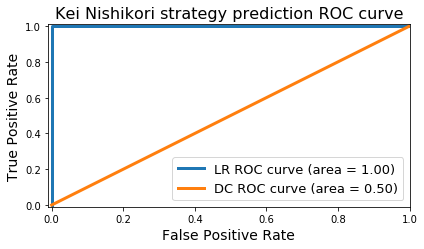

In [24]:
#generate auc_curve for a particular player's LR model

from sklearn.metrics import roc_curve, auc
player_sample='Kei Nishikori'
player_model=[(i[1],i[5],i[6]) for i in lr_scores if i[0]==player_sample]
X_train,X_test,y_train,y_test=train_test_split(player_model[0][1],player_model[0][2])
y_score_lr = player_model[0][0].decision_function(X_test)


fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
dc_fpr_lr, dc_tpr_lr, _ = roc_curve(y_test, [sum(y_train)/len(y_train)]*len(y_test))
roc_auc_lr = auc(fpr_lr, tpr_lr)
dc_roc_auc_lr = auc(dc_fpr_lr, dc_tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LR ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.plot(dc_fpr_lr, dc_tpr_lr, lw=3, label='DC ROC curve (area = {:0.2f})'.format(dc_roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title(player_sample+' strategy prediction ROC curve', fontsize=16)
plt.legend(loc=4,fontsize=13,ncol=1)
plt.axes().set_aspect(.5)
plt.tight_layout()
plt.savefig('risk_strat_predict_ROC.png')

In [102]:
# now we are going to see which matchup's are the most likely to benefit from a risky strat
#when no prior match data is present

df_nm=pd.read_pickle('enhancement_metrics.pkl')
#select matchups with 0 or fewer matches in history
#list that stores list of players where model predictions are greater than just the dummy_scores by 10%

p1_top30=[i for i in active_player_list if i in top_player_list]

#This function collects player matchups that have never occurred by searching for key errors when querying out databse of player matchup
#statistics. We will make strategy predictions for matchups in this pool based on our ML models

def produce_new_matchups(score_list,train_diff,dummy_diff):
    #we also want to add in functionality to restruct ourselves to models that have a certain difference between train/test scores and dummy classifier scores
    model_pool=[name_to_id[score_list[i][0]] for i in range(len(score_list)) if (abs(score_list[i][3]-score_list[i][4])<train_diff) and (score_list[i][4]>dummy_scores[i][3])]
    
    p1_nm=[]
    p2_nm=[]

    #now to get list of players who havent played before, check in the matchup is in the df_nm dataframe, if not that means
    #the matchup hasn't occured

    for i,p2 in enumerate(model_pool):
        
        for p1 in p1_top30:
            if p1==p2:
                continue
            try:
                df_nm.loc[p1,p2]
            except KeyError:
                p1_nm.append(p1)
                p2_nm.append(p2)
            
    return (p1_nm,p2_nm,model_pool)


In [109]:
#now look at model prediciton results for all matchups in this list (restricted to player's in model_pool)
def sort_matchup_predicts(score_list,train_diff,dummy_diff):
    p1_nm,p2_nm,model_pool=produce_new_matchups(score_list,train_diff,dummy_diff)    
    predict_results=[predict_strat(p1_nm[i],p2_nm[i],score_list) for i in range(len(p1_nm)) if p2_nm[i] in model_pool]
    
    #create a sorted list of matchups where the risky strat was preferred, where the sorting is performed my model prediciton probability
    predict_pos=[predict_results[i] for i in range(len(predict_results)) if predict_results[i][0]==True]
    sorted_predicts=sorted(predict_pos,key=lambda x:x[1],reverse=True)
    return sorted_predicts

In [129]:
#construct table of matches

import plotly.graph_objects as go
start=0
stop=10

table_labels=['lr','knn','rfc']
model_predictions=[]

for i,scores_lists in enumerate([lr_scores,knn_scores,rfc_scores]):
    sorted_predicts=sort_matchup_predicts(scores_lists,1,-1)
    model_predictions.append(sorted_predicts)
    fig = go.Figure(data=[go.Table(header=dict(values=['Server', 'Opponent','Prediction probability']),
                 cells=dict(values=[list(map(lambda x:(x[2]),sorted_predicts))[start:stop], list(map(lambda x:(x[3]),sorted_predicts))[start:stop],list(map(lambda x:(round(x[1],2)),sorted_predicts))[start:stop]]))
                     ])
    fig.show()
    fig.write_image(table_labels[i]+'_strat_predictions_table.png')

In [130]:
#we want to look for risky strat matchups that were predicted by all three models
matchup_predicts=[[(i[2],i[3]) for i in j] for j in model_predictions]


def IntersecOfSets(arr1, arr2, arr3): 
    # Converting the arrays into sets 
    s1 = set(arr1) 
    s2 = set(arr2) 
    s3 = set(arr3) 
      
    # Calculates intersection of  
    # sets on s1 and s2 
    set1 = s1.intersection(s2)        
      
    # Calculates intersection of sets 
    # on set1 and s3 
    result_set = set1.intersection(s3) 
      
    # Converts resulting set to list 
    final_list = list(result_set) 
    return final_list 
    
print("Percentage of commonly predicted risky strats: {:.2f}".format(len(IntersecOfSets(matchup_predicts[0],matchup_predicts[1],matchup_predicts[2]))/np.mean([len(ele) for ele in matchup_predicts])))

Percentage of commonly predicted risky strats: 0.30


In [131]:
player_intersect=IntersecOfSets(matchup_predicts[0],matchup_predicts[1],matchup_predicts[2])

intersect_av=[]
for matchup in player_intersect:
    temp=[]
    for model in model_predictions:
        for ele in model:
            if ele[2]==matchup[0] and ele[3]==matchup[1]:
                temp.append(ele[1])
                break
    intersect_av.append(np.mean(temp))
    
sorted_model_av=sorted([[player_intersect[i][0],player_intersect[i][1],intersect_av[i]] for i in range(len(intersect_av))],key=lambda x:x[2],reverse=True)          

In [133]:
start=0
stop=10

fig = go.Figure(data=[go.Table(header=dict(values=['Server', 'Opponent','Prediction probability']),
                 cells=dict(values=[list(map(lambda x:(x[0]),sorted_model_av))[start:stop], list(map(lambda x:(x[1]),sorted_model_av))[start:stop],list(map(lambda x:(round(x[2],2)),sorted_model_av))[start:stop]]))
                     ])
fig.show()
fig.write_image('model_av_strat_predictions_table.png')